In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
training_data = pd.read_csv('data2.csv')
training_data = training_data.loc[:, training_data.columns != 'Unnamed: 0']
training_data.head()

,M,%NecONG,%NecRO,%NecRA,%VolONG,%VolRO,%VolRA,SuONG,SuRO,VisONG,...,F23,F24,F25,F26,F27,F28,F29,F30,F31,%Comp
0,2,0.690000,0.689268,0.595041,0.545455,0.615385,0.541667,0,1,0.0,...,0,0,0,0,0,0,0,0,0,0.726027
1,2,0.570000,0.570000,0.652632,0.500000,0.500000,0.642857,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0.595745
2,2,0.634483,0.634483,0.792144,0.730769,0.730769,0.722222,0,0,0.2,...,0,0,0,0,0,0,0,0,0,0.815789
3,2,0.650000,0.650000,0.652632,0.750000,0.750000,0.642857,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0.590909
4,3,0.683333,0.630573,0.652632,0.833333,0.666667,0.642857,0,3,0.0,...,0,0,0,0,0,0,0,1,0,0.656250


In [4]:
M = training_data.sample(frac=1) # Random
Mtrain, Mtest = train_test_split(M, test_size=0.25)
print("Training shape: " + str(Mtrain.shape) + ". Test shape: " + str(Mtest.shape))

Training shape: (32, 60). Test shape: (11, 60)


In [5]:
y = pd.DataFrame()
y["pred"] = Mtrain["%Comp"]
training_data = Mtrain.drop(["%Comp"], axis=1)

rmse_error = make_scorer(mean_squared_error, greater_is_better=False)

parameters = { 
    'C': [0.8, 0.9, 1],
    'epsilon': [0.04, 0.05, 0.06],
    'gamma': [0.001, 0.003, 0.005, 0.008]
}

svr = GridSearchCV(SVR(), cv=3, param_grid=parameters, scoring=rmse_error)

svr.fit(training_data, y)
print(svr.best_estimator_)

SVR(C=0.8, cache_size=200, coef0=0.0, degree=3, epsilon=0.06, gamma=0.008,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [6]:
training_error = mean_squared_error(Mtrain['%Comp'], 
                                    svr.predict(Mtrain.loc[:, M.columns != '%Comp']))
test_error = mean_squared_error(Mtest['%Comp'], 
                                    svr.predict(Mtest.loc[:, Mtest.columns != '%Comp']))
print('RSME en datos de entrenamiento: ' + str(training_error))
print('RSME en datos de prueba: ' + str(test_error))

RSME en datos de entrenamiento: 0.006286952394657705
RSME en datos de prueba: 0.01182923886669542


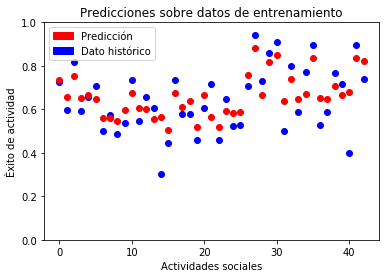

In [7]:
%matplotlib inline
f, ax = plt.subplots(1)
plt.plot(M.index.values, M['%Comp'], 'bo', 
         M.index.values, svr.predict(M.loc[:, M.columns != '%Comp']), 'ro')
ax.set_ylim(ymin=0, ymax=1)
ax.set_title('Predicciones sobre datos de entrenamiento')
ax.set_xlabel('Actividades sociales')
ax.set_ylabel('Èxito de actividad')
red_patch = mpatches.Patch(color='red', label='Predicción')
blue_patch = mpatches.Patch(color='blue', label='Dato histórico')
plt.legend(handles=[red_patch, blue_patch])
plt.show(f)

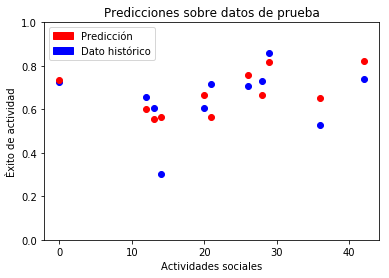

In [8]:
f, ax = plt.subplots(1)
ax.plot(Mtest.index.values, Mtest['%Comp'], 'bo', 
         Mtest.index.values, svr.predict(Mtest.loc[:, Mtest.columns != '%Comp']), 'ro')
ax.set_ylim(ymin=0, ymax=1)
ax.set_title('Predicciones sobre datos de prueba')
ax.set_xlabel('Actividades sociales')
ax.set_ylabel('Èxito de actividad')
red_patch = mpatches.Patch(color='red', label='Predicción')
blue_patch = mpatches.Patch(color='blue', label='Dato histórico')
plt.legend(handles=[red_patch, blue_patch])
plt.show(f)

In [9]:
forest=RandomForestRegressor()
forest.fit(Mtrain.loc[:, Mtest.columns != '%Comp'], Mtrain['%Comp'])
table=pd.concat((pd.DataFrame(Mtrain.iloc[:, 0:].columns, columns = ['variable']), 
           pd.DataFrame(forest.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20].reset_index()
table=table.drop("index",axis=1)
table=table.groupby([table.variable.str[:]]).sum().reset_index().sort_values(by='importance',ascending=False).reset_index()
table=table.drop("index",axis=1)
table.head()

,variable,importance
0,Dias,0.177068
1,M,0.117667
2,%NecONG,0.110623
3,%NecRA,0.087538
4,%NecRO,0.079762


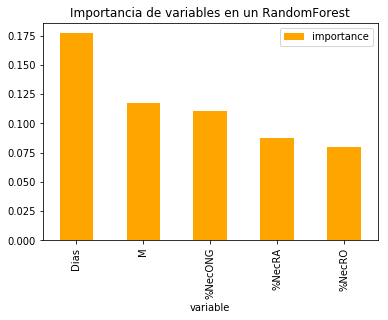

In [10]:
table.head().plot.bar(
    x='variable', 
    color='orange',
    title="Importancia de variables en un RandomForest",
)